In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scienceplots
from tensorflow.python.client import device_lib

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs, reduce_variance, reduce_min, reduce_max
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [2]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
k = 10 # Top 10% highest l2-magnitude filters

In [4]:
def get_F_angle(F):
    
    F = tf.expand_dims(F, -1)
    _, a = getSymAntiSymTF(F)
    a_mag = reduce_euclidean_norm(a, axis=[0,1])[:, 0]

    theta = getSobelTF(F)[:, 0]
    #print(a_mag.shape)
    x =a_mag*np.cos((theta))
    y = a_mag*np.sin((theta))


    cov = np.cov([x,y])
    e_val, e_vec = np.linalg.eig(cov)
    e_vec = e_vec[:, np.argmax(e_val)]
    e_val = np.max(e_val)
    if np.sign(e_vec[0]) != np.sign(x[np.argmax(np.abs(x))]):
        e_vec *= -1
    #print(e_val, e_vec)

    return np.arctan2(e_vec[1], e_vec[0])

[128, 65, 64, 57, 74, 199, 108, 8, 36, 229, 174, 18, 43, 138, 107, 206, 60, 46, 166, 186, 142, 230, 222, 154, 127, 236, 70, 173, 137, 93, 100, 78, 14, 21, 139, 190, 171, 157, 111, 211, 250, 185, 17, 97, 147, 135, 53, 23, 232, 56, 117, 168, 165, 201, 10, 233, 0, 13, 6, 98, 83, 86, 224, 252, 167, 113, 45, 102, 48, 24, 175, 33, 182, 85, 75, 242, 132, 134, 144, 68, 149, 136, 72, 169, 213, 35, 40, 198, 105, 133, 150, 219, 58, 54, 188, 246, 11, 148, 141, 26, 155, 196, 203, 193, 218, 240, 37, 223, 202, 243, 158, 153, 34, 226, 118, 104, 247, 176, 143, 161, 181, 255, 7, 59, 214, 79, 80, 180, 84, 89, 216, 227, 159, 212, 156, 22, 44, 67, 91, 47, 115, 61, 101, 116, 163, 77, 192, 172, 73, 145, 95, 99, 1, 50, 234, 15, 114, 28, 52, 197, 241, 9, 195, 146, 205, 239, 184, 126, 62, 119, 5, 189, 4, 66, 123, 235, 253, 215, 178, 120, 96, 244, 194, 49, 121, 71, 238, 164, 151, 109, 179, 63, 32, 38, 90, 88, 231, 30, 112, 152, 220, 200, 160, 81, 55, 2, 129, 207, 124, 125, 208, 131, 42, 103, 27, 39, 25, 254, 183

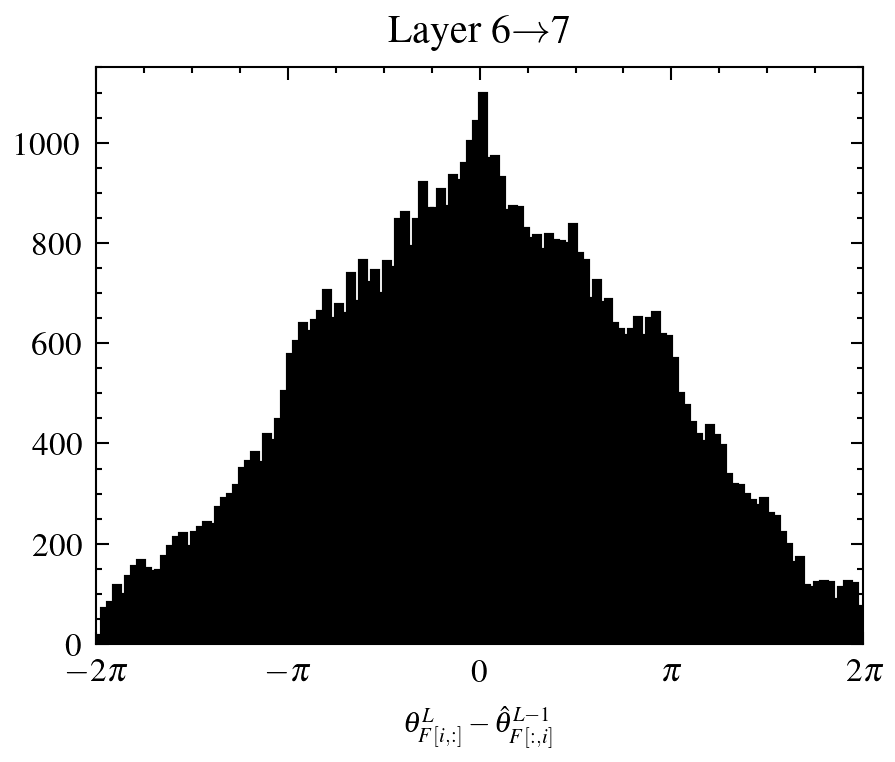

In [23]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        if l.kernel_size == (3,3):
            conv_layers.append(l)


l_num = 6
top10Fprev=topKfilters(model, l_num-1, k=100)
print(top10Fprev)
filtersLprev = get_filter(model, l_num-1)[:,:,:, top10Fprev]
top10F=topKfilters(model, l_num, k=100)
filtersL = get_filter(model, l_num)[:,:,: , top10F]
filtersL = filtersL[:, :, top10Fprev, :]


print("FL", filtersL.shape)

# Get kernels magnitude and theta for layer L
s, a = getSymAntiSymTF(filtersL)
mag = reduce_euclidean_norm(a+s, axis=[0,1])
theta = getSobelTF(filtersL)
 
mag = (mag - reduce_min(mag, axis=0))/(reduce_max(mag, axis=0) - reduce_min(mag, axis=0))

print("AMAG", mag.shape)


#find lims :
angle_diff = []
m = []

for i in range(filtersLprev.shape[-1]):
    
    theta_F_prev = get_F_angle(filtersLprev[:,:,:,i])
    angle_diff.extend(theta_F_prev - theta[:, i])
    #m.extend(mag[:, i].numpy())


#fig.subplots_adjust(left=None, bottom=None, right=0.005, top=0.005)

fig, ax= plt.subplots(1,1)

ax.hist(angle_diff, bins=128, range=(-np.pi, np.pi), edgecolor='black')

# Set the x-axis limits from -2pi to 2pi
ax.set_xlim(-np.pi, np.pi)

#ax.set_ylabel(r"$||f||$ (scaled Min-Max)", fontsize=7)
#ax.set_ylabel(r"Count", fontsize=7)
#ax.set_xlabel(r"$\cos(\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]})$", fontsize=7)

ax.set_xlabel(r"$\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]}$", fontsize=7)

ax.set_title(f"Layer {l_num}"+r"$\rightarrow$"+f"{l_num+1}")

# Add x-axis labels in terms of pi
ax.set_xticks([-2*np.pi,-np.pi, 0, np.pi, 2*np.pi])
ax.set_xticklabels([r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$'])


plt.show() 


(array([1., 6., 3., 2., 3., 5., 4., 1., 4., 3.]),
 array([0.04293392, 0.13864052, 0.23434713, 0.33005375, 0.42576036,
        0.521467  , 0.61717355, 0.7128802 , 0.8085868 , 0.9042934 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

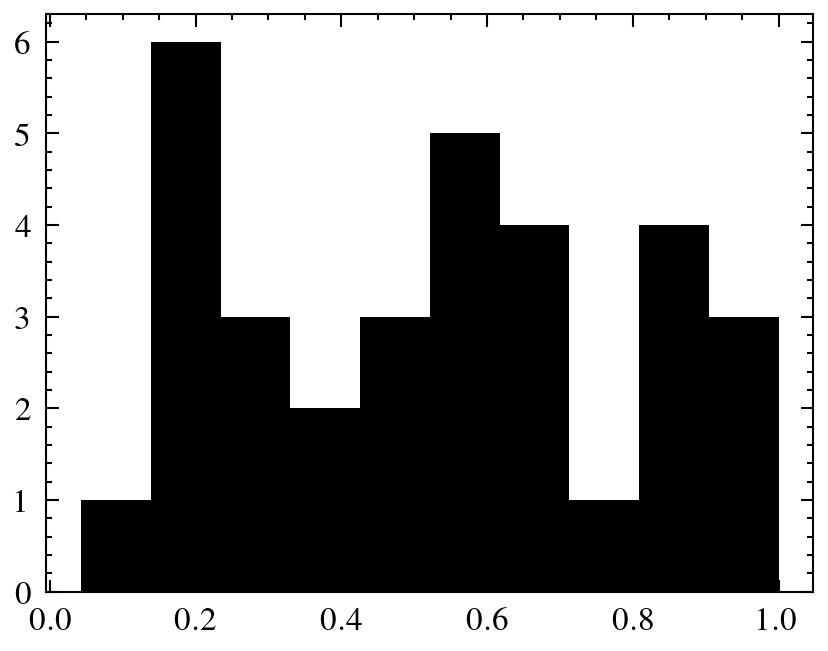

In [ ]:
plt.hist(m)

In [ ]:
reduce_variance(filters, axis=None)

NameError: name 'filters' is not defined

In [ ]:
fig.subplots_adjust(wspace=0.025, hspace=0.025)
plt.show()

NameError: name 'fig' is not defined

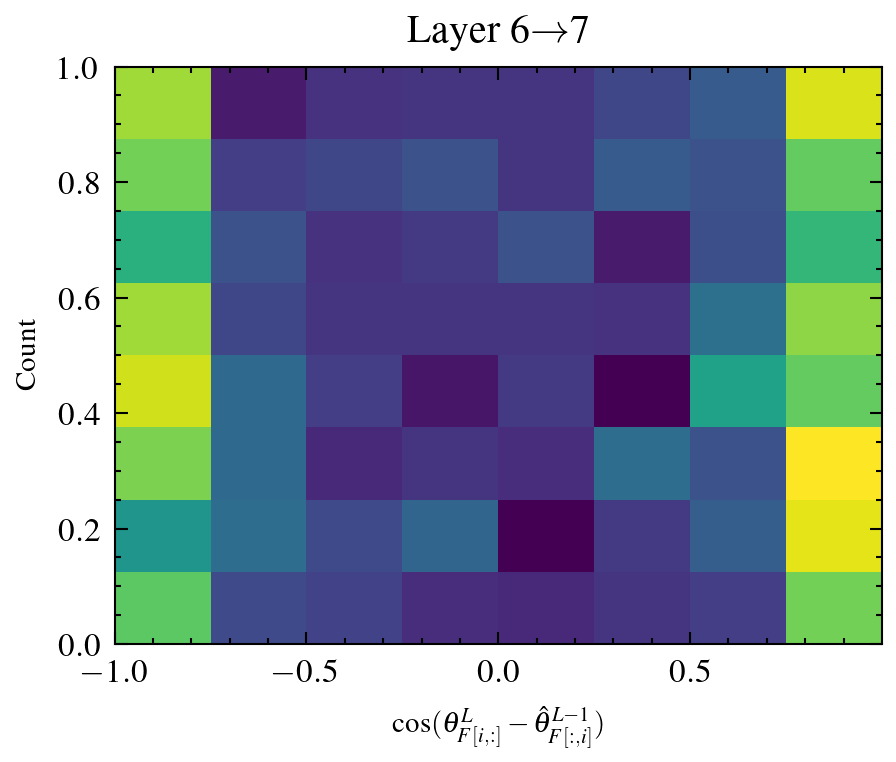

In [ ]:
fig, ax= plt.subplots(1,1)
ax.hist2d(t, m, bins=8)
#ax.set_ylabel(r"$||f||$ (scaled Min-Max)", fontsize=7)
ax.set_ylabel(r"Count", fontsize=7)
ax.set_xlabel(r"$\cos(\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]})$", fontsize=7)
ax.set_title(f"Layer {l_num}"+r"$\rightarrow$"+f"{l_num+1}")


plt.show() 
